# Metrics Calculation

In [2]:
import pandas as pd
import json
import ast

# Load original CSV
df = pd.read_csv("../Classification/NER_with_ensemble_sentiment.csv")

# Safe JSON parser that handles both "" and '' quote styles
def safe_parse(dirty_str):
    if pd.isna(dirty_str) or dirty_str.strip() == '':
        return {}
    try:
        # Try standard JSON first
        return json.loads(dirty_str)
    except:
        try:
            # Try ast.literal_eval for mixed quote JSON-like strings
            return ast.literal_eval(dirty_str)
        except:
            return {}

# Fix function to standardize structure
def fix_sentiment_structure(parsed, annotator_key):
    fixed = {}
    if not isinstance(parsed, dict):
        return fixed
    for company, value in parsed.items():
        # Case 1: already in the right structure
        if isinstance(value, dict) and annotator_key in value:
            fixed[company] = value
        # Case 2: flat structure like {"MSFT": {"label": "Neutral"}}
        elif isinstance(value, dict) and "label" in value:
            fixed[company] = {annotator_key: {"label": value["label"]}}
    return fixed

# Apply cleaning
df['human1_sentiment'] = df['human1_sentiment'].apply(lambda x: fix_sentiment_structure(safe_parse(x), 'human1'))
df['human2_sentiment'] = df['human2_sentiment'].apply(lambda x: fix_sentiment_structure(safe_parse(x), 'human2'))

# Save cleaned file
output_path = "../Classification/NER_with_ensemble_sentiment_cleaned.csv"
df.to_csv(output_path, index=False)

print(f"✅ Cleaned CSV saved to: {output_path}")


✅ Cleaned CSV saved to: ../Classification/NER_with_ensemble_sentiment_cleaned.csv


In [4]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report

df = pd.read_csv("../Classification/NER_with_ensemble_sentiment_cleaned.csv")
df.head()

,id,subreddit,author,score,created_utc,type,num_comments,permalink,title,selftext,...,unique_word_count,ner_text_cleaned,ner_recognized_tickers,ner_entity_sentiments,qwen_sentiments,human1_sentiment,human2_sentiment,ensemble_results,primary_sentiment,primary_score
0,1iy04ol,applestocks,No-Drive8630,2,1740503556,post,3.0,https://www.reddit.com/r/applestocks/comments/...,Buy apple today! ????,Stock is up compared to the market. Board vot...,...,26,Buy AAPL today Stock is up compared to the mar...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Slightly Posit...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Slightly Positi...,{'AAPL': {'human2': {'label': 'Slightly Positi...,"{'AAPL': {'sentiment': 'slightly positive', 's...",slightly positive,0.410751
1,1ixdqih,applestocks,DekeJeffery,2,1740432978,post,1.0,https://www.reddit.com/r/applestocks/comments/...,Apple will spend more than $500 billion in the...,NaN,...,15,AAPL will spend more than 500 billion in the U...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},{'AAPL': {'human2': {'label': 'Neutral'}}},"{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
2,1iunfst,applestocks,DekeJeffery,3,1740131997,post,1.0,https://www.reddit.com/r/applestocks/comments/...,"AAPL iPhone 16e Built for A.I., Weighing Headw...",NaN,...,10,AAPL AAPL 16e Built for A I Weighing Headwinds...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Neutral'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},{'AAPL': {'human2': {'label': 'Neutral'}}},"{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
3,1iu3lir,applestocks,thesatisfiedplethora,0,1740071513,post,2.0,https://www.reddit.com/r/applestocks/comments/...,FAQ For Getting Payment On Apple $490M Investo...,"Hey guys, I posted about this settlement recen...",...,142,FAQ For Getting Payment On AAPL 490M Investor ...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Neutral"", ""net...",{'AAPL': {'qwen': {'label': 'Neutral'}}},{'AAPL': {'human1': {'label': 'Neutral'}}},{'AAPL': {'human2': {'label': 'Neutral'}}},"{'AAPL': {'sentiment': 'neutral', 'score': 0.0...",neutral,0.000000
4,1ifidhu,applestocks,goldenson,1,1738449363,post,0.0,https://www.reddit.com/r/applestocks/comments/...,Below is a structured extraction of key highli...,**Below is a structured extraction of key high...,...,393,Below is a structured extraction of key highli...,AAPL,"{""AAPL"": {""finbert"": {""label"": ""Slightly Posit...",{'AAPL': {'qwen': {'label': 'Positive'}}},{'AAPL': {'human1': {'label': 'Slightly Positi...,{'AAPL': {'human2': {'label': 'Slightly Positi...,"{'AAPL': {'sentiment': 'slightly positive', 's...",slightly positive,0.642683


## Inter-Annotator Agreement

Total paired labels found: 1264
Cohen's kappa: 0.8028
Percent agreement: 88.29%


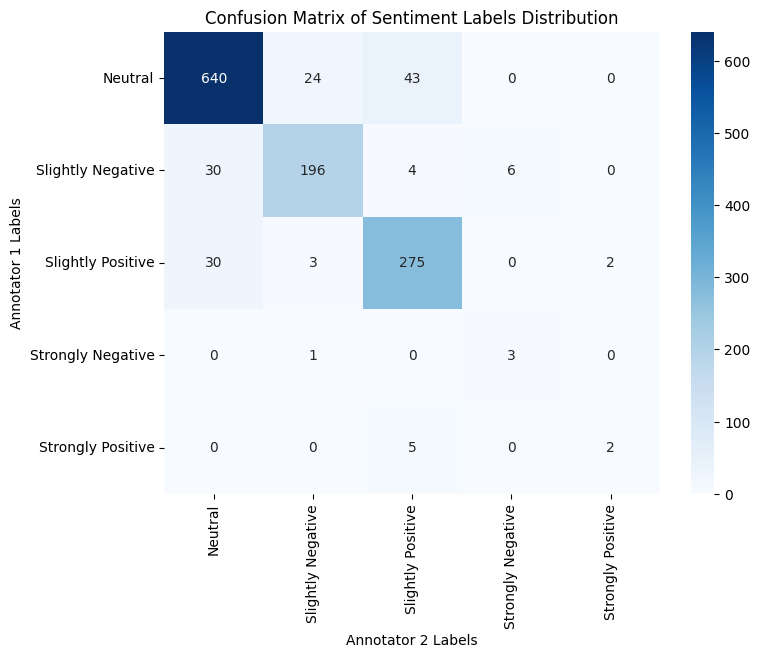

In [5]:
def safe_json_parse(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except:
            return {}
    return x if isinstance(x, dict) else {}

h1_labels = []
h2_labels = []

for idx, row in df.iterrows():
    h1 = safe_json_parse(row['human1_sentiment'])
    h2 = safe_json_parse(row['human2_sentiment'])
    
    companies = set(h1.keys()).intersection(h2.keys())
    for company in companies:
        def get_first_label(data):
            for annotator in data.get(company, {}):
                levels = data[company][annotator]
                if isinstance(levels, dict):
                    for value in levels.values():
                        return value
            return None
        
        h1_label = get_first_label(h1)
        h2_label = get_first_label(h2)
        
        if h1_label is not None and h2_label is not None:
            h1_labels.append(h1_label)
            h2_labels.append(h2_label)

# Calculate Cohen's kappa and percent agreement
if h1_labels and h2_labels:
    kappa = cohen_kappa_score(h1_labels, h2_labels)
    agreement = sum([h1 == h2 for h1, h2 in zip(h1_labels, h2_labels)]) / len(h1_labels)
    
    print(f"Total paired labels found: {len(h1_labels)}")
    print(f"Cohen's kappa: {kappa:.4f}")
    print(f"Percent agreement: {agreement:.2%}")
    
    # Generate confusion matrix
    labels = sorted(list(set(h1_labels) | set(h2_labels)))
    cm = confusion_matrix(h1_labels, h2_labels, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Annotator 2 Labels')
    plt.ylabel('Annotator 1 Labels')
    plt.title('Confusion Matrix of Sentiment Labels Distribution')
    plt.show()
else:
    print("No matching label pairs found for comparison.")


## Evaluation Metrics

In [ ]:
def safe_json_parse(x):
    if isinstance(x, str):
        try:
            return json.loads(x.replace("'", '"'))
        except:
            return {}
    return x if isinstance(x, dict) else {}

def evaluate_annotator(df, human_col):
    human_labels = []
    ens_labels = []
    
    for idx, row in df.iterrows():
        human = safe_json_parse(row[human_col])
        ens = safe_json_parse(row['ensemble_results'])
        companies = set(human.keys()).intersection(ens.keys())
        
        for company in companies:
            def get_first_label(data):
                for annotator in data.get(company, {}):
                    levels = data[company][annotator]
                    if isinstance(levels, dict):
                        for value in levels.values():
                            return value
                return None
            
            human_label = get_first_label(human)
            
            ens_label = ens.get(company, {}).get('sentiment')
            
            if human_label is not None and ens_label is not None:
                human_labels.append(human_label)
                ens_labels.append(ens_label.title() if isinstance(ens_label, str) else ens_label)
    
    if human_labels and ens_labels:
        accuracy = accuracy_score(human_labels, ens_labels)
        precision = precision_score(human_labels, ens_labels, average='weighted', zero_division=0)
        recall = recall_score(human_labels, ens_labels, average='weighted', zero_division=0)
        f1 = f1_score(human_labels, ens_labels, average='weighted', zero_division=0)
        report = classification_report(human_labels, ens_labels, zero_division=0)
        
        # Create confusion matrix
        labels = sorted(list(set(human_labels) | set(ens_labels)))
        cm = confusion_matrix(human_labels, ens_labels, labels=labels)
        
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'report': report,
            'n': len(human_labels),
            'human_labels': human_labels,
            'ens_labels': ens_labels,
            'confusion_matrix': cm,
            'labels': labels
        }
    return None

### Human 1

Individual Evaluation Results (Human1 vs Ensemble):
Accuracy: 0.7405
Precision: 0.7583
Recall: 0.7405
F1 Score: 0.7456
Total samples: 1264

Classification Report (Human1):
                   precision    recall  f1-score   support

          Neutral       0.81      0.79      0.80       707
Slightly Negative       0.77      0.58      0.67       236
Slightly Positive       0.66      0.77      0.71       310
Strongly Negative       0.09      0.25      0.13         4
Strongly Positive       0.05      0.14      0.07         7

         accuracy                           0.74      1264
        macro avg       0.47      0.51      0.48      1264
     weighted avg       0.76      0.74      0.75      1264



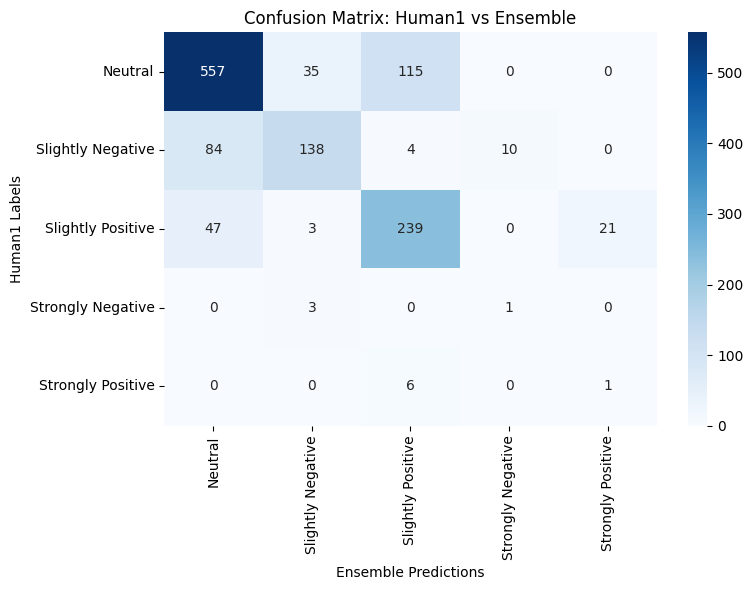

In [7]:
results_h1 = evaluate_annotator(df, 'human1_sentiment')
print("Individual Evaluation Results (Human1 vs Ensemble):")
print(f"Accuracy: {results_h1['accuracy']:.4f}")
print(f"Precision: {results_h1['precision']:.4f}")
print(f"Recall: {results_h1['recall']:.4f}")
print(f"F1 Score: {results_h1['f1']:.4f}")
print(f"Total samples: {results_h1['n']}")
print("\nClassification Report (Human1):\n" + results_h1['report'])

# Visualize confusion matrix for Human1
plt.figure(figsize=(8, 6))
sns.heatmap(results_h1['confusion_matrix'], annot=True, fmt='d', 
            xticklabels=results_h1['labels'], yticklabels=results_h1['labels'], cmap='Blues')
plt.xlabel('Ensemble Predictions')
plt.ylabel('Human1 Labels')
plt.title('Confusion Matrix: Human1 vs Ensemble')
plt.tight_layout()
plt.show()

### Human 2


Individual Evaluation Results (Human2 vs Ensemble):
Accuracy: 0.6404
Precision: 0.6588
Recall: 0.6404
F1 Score: 0.6436
Total samples: 2439

Classification Report (Human2):
                   precision    recall  f1-score   support

          Neutral       0.73      0.62      0.67      1264
Slightly Negative       0.65      0.56      0.60       393
Slightly Positive       0.57      0.73      0.64       737
Strongly Negative       0.24      0.29      0.26        17
Strongly Positive       0.23      0.50      0.32        28

         accuracy                           0.64      2439
        macro avg       0.48      0.54      0.50      2439
     weighted avg       0.66      0.64      0.64      2439



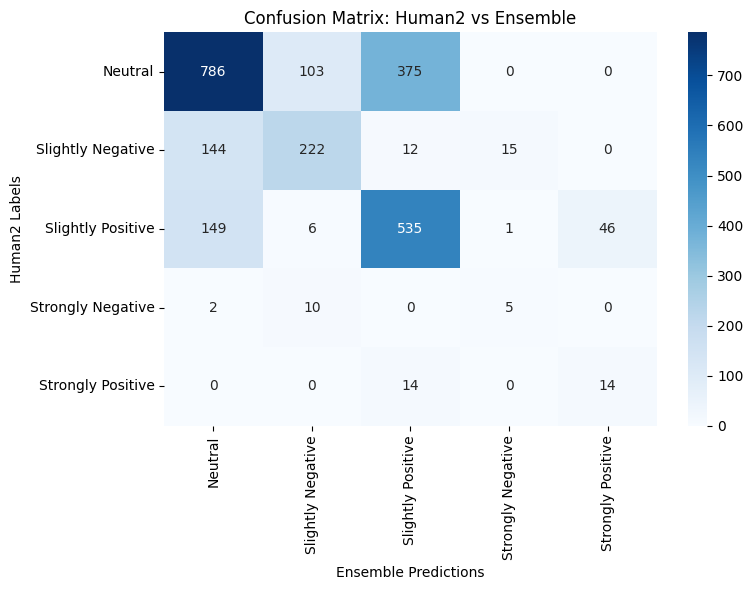

In [8]:
results_h2 = evaluate_annotator(df, 'human2_sentiment')
print("\nIndividual Evaluation Results (Human2 vs Ensemble):")
print(f"Accuracy: {results_h2['accuracy']:.4f}")
print(f"Precision: {results_h2['precision']:.4f}")
print(f"Recall: {results_h2['recall']:.4f}")
print(f"F1 Score: {results_h2['f1']:.4f}")
print(f"Total samples: {results_h2['n']}")
print("\nClassification Report (Human2):\n" + results_h2['report'])

# Visualize confusion matrix for Human2
plt.figure(figsize=(8, 6))
sns.heatmap(results_h2['confusion_matrix'], annot=True, fmt='d', 
            xticklabels=results_h2['labels'], yticklabels=results_h2['labels'], cmap='Blues')
plt.xlabel('Ensemble Predictions')
plt.ylabel('Human2 Labels')
plt.title('Confusion Matrix: Human2 vs Ensemble')
plt.tight_layout()
plt.show()

### Overall


Overall Evaluation Results (Weighted Average):
Accuracy: 0.6746
Precision: 0.6928
Recall: 0.6746
F1 Score: 0.6784
Total samples: 3703

Overall Evaluation Results (Pooled Labels):
Accuracy: 0.6746
Precision: 0.6928
Recall: 0.6746
F1 Score: 0.6789


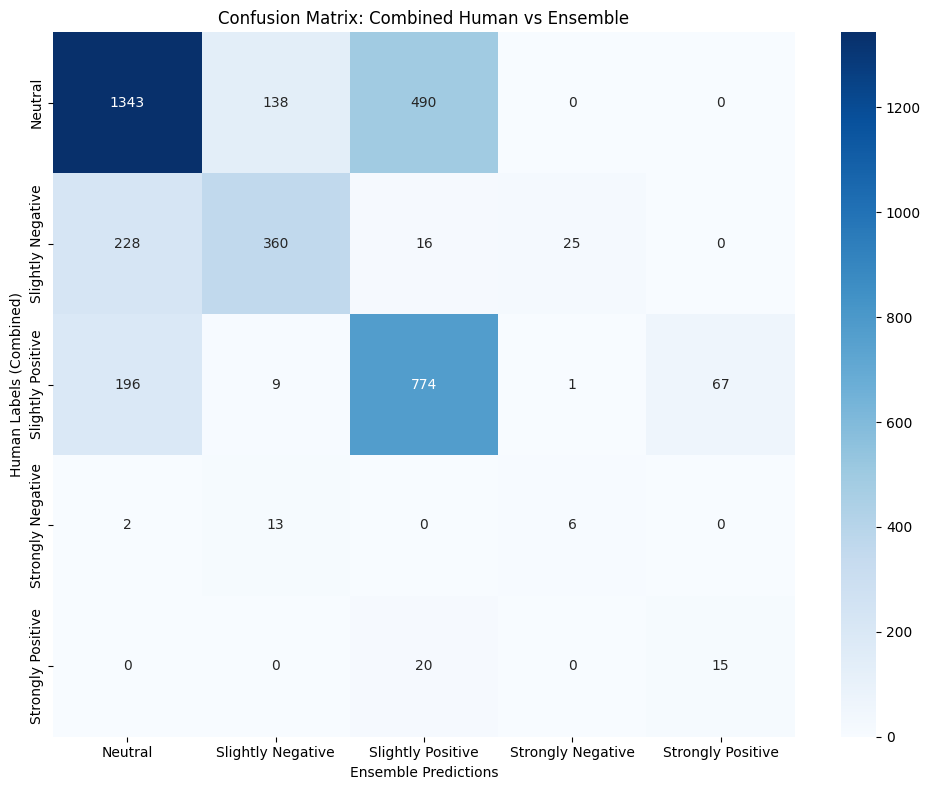

In [9]:
n_total = results_h1['n'] + results_h2['n']

overall_results = {
    'accuracy': (results_h1['accuracy'] * results_h1['n'] + 
                    results_h2['accuracy'] * results_h2['n']) / n_total,
    'precision': (results_h1['precision'] * results_h1['n'] + 
                    results_h2['precision'] * results_h2['n']) / n_total,
    'recall': (results_h1['recall'] * results_h1['n'] + 
                results_h2['recall'] * results_h2['n']) / n_total,
    'f1': (results_h1['f1'] * results_h1['n'] + 
            results_h2['f1'] * results_h2['n']) / n_total,
    'total_samples': n_total
}

print("\nOverall Evaluation Results (Weighted Average):")
print(f"Accuracy: {overall_results['accuracy']:.4f}")
print(f"Precision: {overall_results['precision']:.4f}")
print(f"Recall: {overall_results['recall']:.4f}")
print(f"F1 Score: {overall_results['f1']:.4f}")
print(f"Total samples: {overall_results['total_samples']}")

# Optional: Calculate metrics by pooling all labels
all_human_labels = results_h1['human_labels'] + results_h2['human_labels']
all_ens_labels = results_h1['ens_labels'] + results_h2['ens_labels']

pooled_accuracy = accuracy_score(all_human_labels, all_ens_labels)
pooled_precision = precision_score(all_human_labels, all_ens_labels, average='weighted', zero_division=0)
pooled_recall = recall_score(all_human_labels, all_ens_labels, average='weighted', zero_division=0)
pooled_f1 = f1_score(all_human_labels, all_ens_labels, average='weighted', zero_division=0)

print("\nOverall Evaluation Results (Pooled Labels):")
print(f"Accuracy: {pooled_accuracy:.4f}")
print(f"Precision: {pooled_precision:.4f}")
print(f"Recall: {pooled_recall:.4f}")
print(f"F1 Score: {pooled_f1:.4f}")

# Create a combined confusion matrix
all_labels = sorted(list(set(all_human_labels) | set(all_ens_labels)))
cm_combined = confusion_matrix(all_human_labels, all_ens_labels, labels=all_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_combined, annot=True, fmt='d', 
            xticklabels=all_labels, yticklabels=all_labels, cmap='Blues')
plt.xlabel('Ensemble Predictions')
plt.ylabel('Human Labels (Combined)')
plt.title('Confusion Matrix: Combined Human vs Ensemble')
plt.tight_layout()
plt.show()


## Random Test

In [18]:
def random_accuracy_test(test_df):
    possible_labels = ['strongly positive', 'strongly negative', 'slightly positive', 'slightly negative', 'neutral']
    
    # Extract ensemble predicted labels from the ensemble_results column
    def extract_ensemble_label(row):
        ens = row['ensemble_results']
        if isinstance(ens, str):
            try:
                ens = json.loads(ens.replace("'", '"'))
            except:
                return np.nan
        if isinstance(ens, dict):
            # Get all company sentiments in this row
            sentiments = []
            for company in ens:
                if isinstance(ens[company], dict) and 'sentiment' in ens[company]:
                    sentiment = ens[company]['sentiment']
                    # Handle case where sentiment might be a string or another type
                    if isinstance(sentiment, str):
                        sentiments.append(sentiment.lower())
                    else:
                        sentiments.append(str(sentiment).lower())
            # Return the first sentiment (or you could implement other logic)
            if sentiments:
                return sentiments[0]
        return np.nan

    # Get ensemble predicted labels
    test_df = test_df.copy()
    test_df['predicted_label'] = test_df.apply(extract_ensemble_label, axis=1)
    # Drop rows where ensemble label is missing
    test_df = test_df.dropna(subset=['predicted_label'])
    
    # If the dataset is empty after filtering, return early
    if len(test_df) == 0:
        print("No valid ensemble predictions found in the dataset.")
        return {
            'error': 'No valid ensemble predictions found in the dataset.'
        }

    # Calculate random accuracy based on the distribution of labels in the dataset
    label_counts = test_df['predicted_label'].value_counts()
    label_probabilities = label_counts / label_counts.sum()
    
    # Ensure probabilities are in the order of possible_labels
    p = [label_probabilities.get(l, 0) for l in possible_labels]
    # If sum(p) < 1 due to missing labels, normalize
    if sum(p) > 0:
        p = [x / sum(p) for x in p]
    else:
        p = [1/len(possible_labels)] * len(possible_labels)

    # Simulate random predictions based on label probabilities
    random_predictions = np.random.choice(possible_labels, size=len(test_df), p=p)

    # Get true labels from the DataFrame
    true_labels = test_df['predicted_label']

    # Calculate evaluation metrics for random predictions
    accuracy_random = accuracy_score(true_labels, random_predictions)
    precision_random = precision_score(true_labels, random_predictions, average='weighted', labels=possible_labels, zero_division=0)
    recall_random = recall_score(true_labels, random_predictions, average='weighted', labels=possible_labels, zero_division=0)
    f1_random = f1_score(true_labels, random_predictions, average='weighted', labels=possible_labels, zero_division=0)

    # Print the evaluation metrics
    print(f"Random Accuracy: {accuracy_random:.2%}")
    print(f"Random Precision: {precision_random:.2%}")
    print(f"Random Recall: {recall_random:.2%}")
    print(f"Random F1 Score: {f1_random:.2%}")

In [19]:
def has_human_annotation(row, human_col):
    """Check if a row has any human annotations in the specified column"""
    human_data = safe_json_parse(row[human_col])
    if not human_data:
        return False
    
    # Check if there are any companies with annotations
    for company in human_data:
        for annotator in human_data.get(company, {}):
            levels = human_data[company][annotator]
            if isinstance(levels, dict) and any(levels.values()):
                return True
    return False

# Identify rows without human annotations
df_unlabeled = df[~df.apply(lambda row: has_human_annotation(row, 'human1_sentiment') and 
                                        has_human_annotation(row, 'human2_sentiment'), axis=1)]

# Now run the random accuracy test on truly unlabeled data
random_accuracy_test(df_unlabeled)


Random Accuracy: 40.13%
Random Precision: 40.21%
Random Recall: 40.13%
Random F1 Score: 40.17%
